# In Hospital Mortality Prediction

## Background
This project is using the kaggle in hospital mortality prediction dataset.

https://www.kaggle.com/datasets/saurabhshahane/in-hospital-mortality-prediction

The predictors of in-hospital mortality for intensive care units (ICU)-admitted HF patients remain poorly characterized. We aimed to develop and validate a prediction model for all-cause in-hospital mortality among ICU-admitted HF patients.


The goal from this project is help patients by creating a model to more accurately characterize patients.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
# from sklearn import metrics

import wandb
from wandb.xgboost import WandbCallback

from evidently import ColumnMapping
from evidently.report import Report
from evidently.metrics import ColumnDriftMetric, DatasetDriftMetric, DatasetMissingValuesMetric

/Users/qavila/.pyenv/versions/3.9.12/envs/tricorderai/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df=pd.read_csv("data/data01.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1177 entries, 0 to 1176
Data columns (total 51 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   group                     1177 non-null   int64  
 1   ID                        1177 non-null   int64  
 2   outcome                   1176 non-null   float64
 3   age                       1177 non-null   int64  
 4   gendera                   1177 non-null   int64  
 5   BMI                       962 non-null    float64
 6   hypertensive              1177 non-null   int64  
 7   atrialfibrillation        1177 non-null   int64  
 8   CHD with no MI            1177 non-null   int64  
 9   diabetes                  1177 non-null   int64  
 10  deficiencyanemias         1177 non-null   int64  
 11  depression                1177 non-null   int64  
 12  Hyperlipemia              1177 non-null   int64  
 13  Renal failure             1177 non-null   int64  
 14  COPD    

We know group and ID is not needed for the model and will drop 'group' and 'ID'

In [3]:
df.drop(['group','ID'],axis=1,inplace=True)

Lets check na fields

In [4]:
df.isna().sum()

outcome                       1
age                           0
gendera                       0
BMI                         215
hypertensive                  0
atrialfibrillation            0
CHD with no MI                0
diabetes                      0
deficiencyanemias             0
depression                    0
Hyperlipemia                  0
Renal failure                 0
COPD                          0
heart rate                   13
Systolic blood pressure      16
Diastolic blood pressure     16
Respiratory rate             13
temperature                  19
SP O2                        13
Urine output                 36
hematocrit                    0
RBC                           0
MCH                           0
MCHC                          0
MCV                           0
RDW                           0
Leucocyte                     0
Platelets                     0
Neutrophils                 144
Basophils                   259
Lymphocyte                  145
PT      

We are going to be using 'outcome' as Y. Lets fix that na

In [5]:
rows_with_missing_outcome = df.loc[df['outcome'].isna()]
rows_with_missing_outcome

outcome  age  gendera  BMI  hypertensive  atrialfibrillation  \
1159      NaN   83        1  NaN             1                   0   

      CHD with no MI  diabetes  deficiencyanemias  depression  ...  \
1159               0         1                  0           0  ...   

      Blood sodium  Blood calcium  Chloride  Anion gap  Magnesium ion  PH  \
1159    130.666667           7.45    92.625       15.5       1.983333 NaN   

      Bicarbonate  Lactic acid  PCO2  EF  
1159         26.5          NaN   NaN  55  

[1 rows x 49 columns]

In [6]:
df = df.dropna(subset=['outcome'])

Number of survivors:  1017
Number of deaths:  159


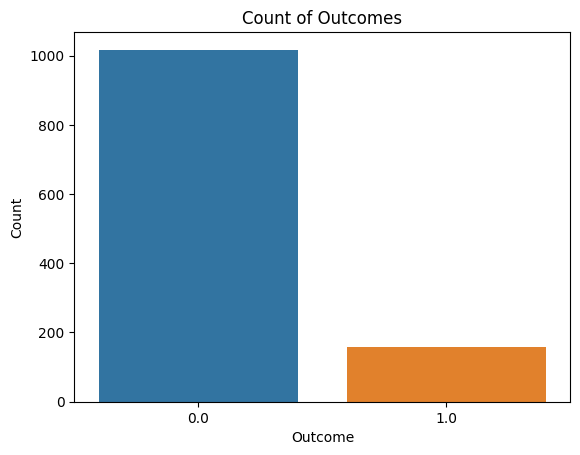

In [26]:
ax = sns.countplot(x='outcome', data=df)
ax.set(xlabel='Outcome', ylabel='Count')
ax.set_title('Count of Outcomes')

Life, Death = df['outcome'].value_counts()
print('Number of survivors: ', Life)
print('Number of deaths: ', Death)

Number of survivors:  1017
Number of deaths:  159


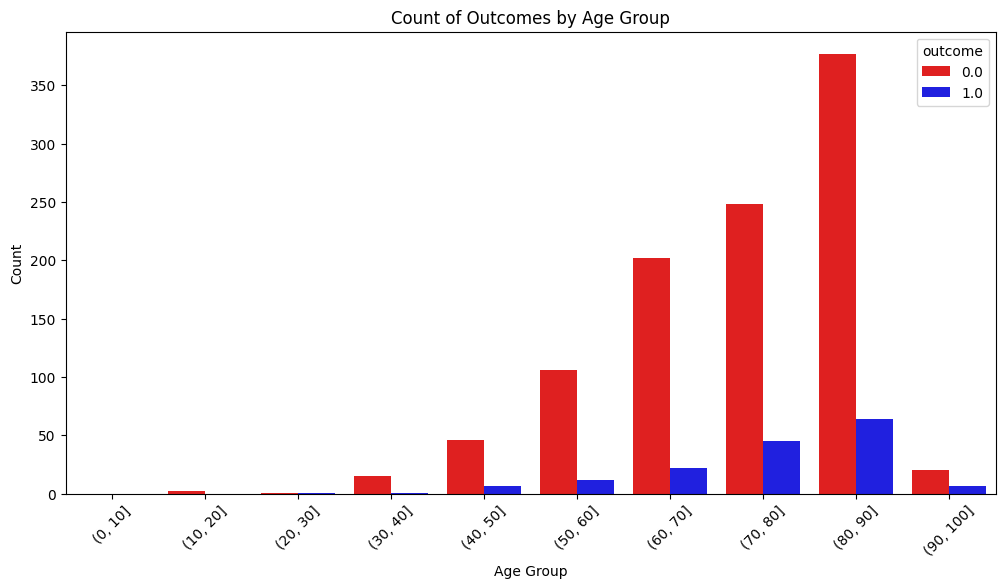

In [27]:

plt.figure(figsize=(12, 6))

age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
ax = sns.countplot(x=pd.cut(df['age'], bins=age_bins), hue='outcome', data=df, palette={0: 'red', 1: 'blue'})
ax.set(xlabel='Age Group', ylabel='Count')
ax.set_title('Count of Outcomes by Age Group')

Life, Death = df['outcome'].value_counts()
print('Number of survivors: ', Life)
print('Number of deaths: ', Death)

plt.xticks(rotation=45)

plt.show()

The purpose of the project is MLOps focused so to save time I will look at feature importance using xgboost. And of course track our experiments using WandB.

In [28]:
df.describe()

outcome          age      gendera         BMI  hypertensive  \
count  1176.000000  1176.000000  1176.000000  962.000000   1176.000000   
mean      0.135204    74.047619     1.525510   30.188278      0.717687   
std       0.342087    13.437241     0.499561    9.325997      0.450316   
min       0.000000    19.000000     1.000000   13.346801      0.000000   
25%       0.000000    65.000000     1.000000   24.326461      0.000000   
50%       0.000000    77.000000     2.000000   28.312474      1.000000   
75%       0.000000    85.000000     2.000000   33.633509      1.000000   
max       1.000000    99.000000     2.000000  104.970366      1.000000   

       atrialfibrillation  CHD with no MI     diabetes  deficiencyanemias  \
count         1176.000000     1176.000000  1176.000000        1176.000000   
mean             0.451531        0.085884     0.420918           0.339286   
std              0.497857        0.280312     0.493917           0.473668   
min              0.000000        0.000000     0.000000           0.000000   
25%              0.000000        0.000000     0.000000           0.000000   
50%              0.000000        0.000000     0.000000           0.000000   
75%              1.000000        0.000000     1.000000           1.000000   
max              1.000000        1.000000     1.000000           1.000000   

        depression  ...  Blood sodium  Blood calcium     Chloride  \
count  1176.000000  ...   1176.000000    1175.000000  1176.000000   
mean      0.119048  ...    138.897009       8.501789   102.292048   
std       0.323982  ...      4.146172       0.571683     5.334562   
min       0.000000  ...    114.666667       6.700000    80.266667   
25%       0.000000  ...    136.666667       8.150000    99.000000   
50%       0.000000  ...    139.250000       8.500000   102.516667   
75%       0.000000  ...    141.600000       8.869375   105.571429   
max       1.000000  ...    154.736842      10.950000   122.526316   

         Anion gap  Magnesium ion          PH  Bicarbonate  Lactic acid  \
count  1176.000000    1176.000000  885.000000  1176.000000   948.000000   
mean     13.923755       2.120286    7.378532    26.912116     1.853426   
std       2.653463       0.251608    0.067320     5.169696     0.983819   
min       6.636364       1.400000    7.090000    12.857143     0.500000   
25%      12.250000       1.955556    7.334615    23.452020     1.200000   
50%      13.666667       2.092582    7.380000    26.500000     1.600000   
75%      15.404167       2.241964    7.430000    29.881250     2.200000   
max      25.500000       4.072727    7.580000    47.666667     8.333333   

             PCO2           EF  
count  883.000000  1176.000000  
mean    45.535382    48.710034  
std     12.711271    12.872604  
min     18.750000    15.000000  
25%     37.038462    40.000000  
50%     43.000000    55.000000  
75%     50.585784    55.000000  
max     98.600000    75.000000  

[8 rows x 49 columns]

In [16]:
# Split the data into features (X) and target (y)
X = df.drop('outcome', axis=1)
y = df['outcome']

In [32]:
def run_train(X, y):
    run = wandb.init(project="mlops-mortality-prediction", job_type='train-model')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Define the XGBoost model and set hyperparameters
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=3,    
        learning_rate=0.1,
        reg_alpha=0.1,  
        reg_lambda=0.1,
        random_state=42,
        callbacks=[WandbCallback(log_model=True)]
    )


    # Train the XGBoost model
    xgb_model.fit(X_train, y_train)

    # Make predictions on the training set
    y_train_pred = xgb_model.predict(X_train)

    # Make predictions on the test set
    y_test_pred = xgb_model.predict(X_test)

    # Calculate accuracy for training and testing sets
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Calculate F1 score for training and testing sets
    train_f1_score = f1_score(y_train, y_train_pred)
    test_f1_score = f1_score(y_test, y_test_pred)

    # Calculate AUC-ROC score for training and testing sets
    train_auc_roc = roc_auc_score(y_train, xgb_model.predict_proba(X_train)[:, 1])
    test_auc_roc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])


    print("Training Accuracy:", train_accuracy)
    print("Testing Accuracy:", test_accuracy)
    print("Training F1 Score:", train_f1_score)
    print("Testing F1 Score:", test_f1_score)
    print("Training AUC-ROC:", train_auc_roc)
    print("Testing AUC-ROC:", test_auc_roc)

    run.log({
        "Train/Accuracy": train_accuracy,
        "Testing/Accuracy": test_accuracy,
        "Train/F1 Score": train_f1_score,
        "Testing/F1 Score": test_f1_score,
        "Train/AUC-ROC": train_auc_roc,
        "Testing/AUC-ROC": test_auc_roc
    })
    

    run.finish()
    return xgb_model

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: qmavila. Use `wandb login --relogin` to force relogin


Training Accuracy: 0.9840425531914894
Testing Accuracy: 0.864406779661017
Training F1 Score: 0.9327354260089686
Testing F1 Score: 0.40740740740740744
Training AUC-ROC: 0.9999283513649064
Testing AUC-ROC: 0.7744897959183674


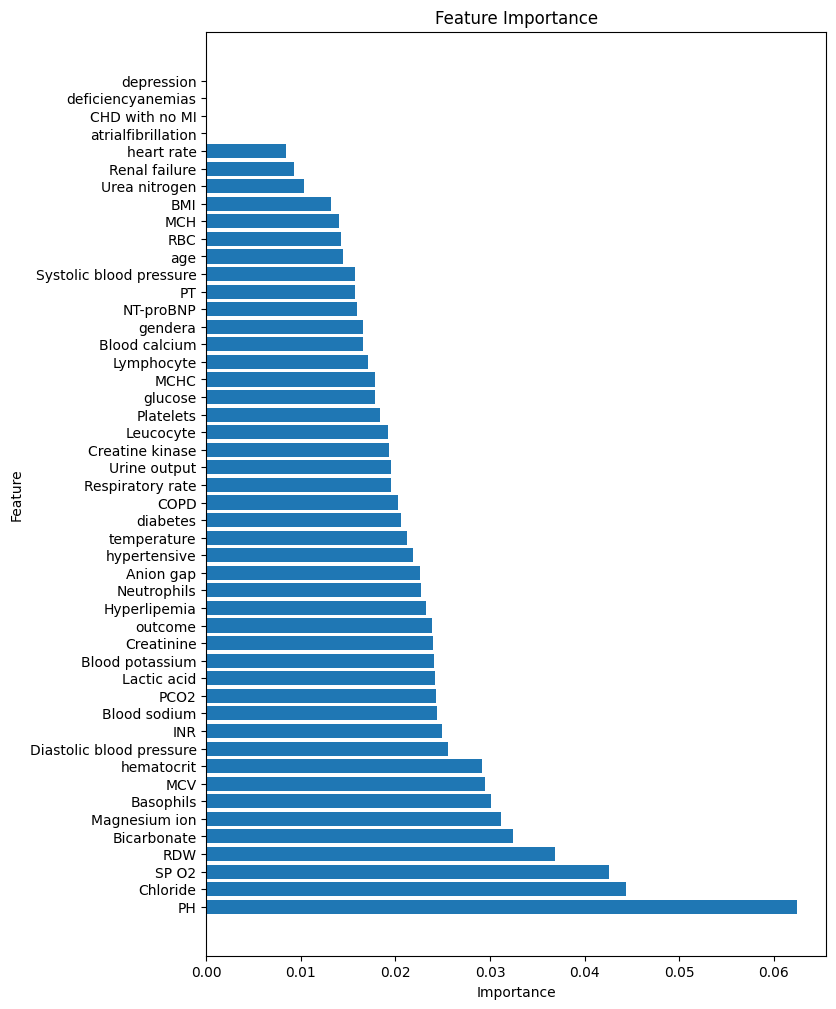

In [33]:
test_model = run_train(X, y)
feature_importances = test_model.feature_importances_

feature_importance_pairs = zip(df.columns, feature_importances)

sorted_feature_importance = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

features, importances = zip(*sorted_feature_importance)
plt.figure(figsize=(8, 12))
plt.barh(features, importances)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

Lets run WandB sweep for more experiment analysis

# WandB sweep

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
sweep_config = {
  "method" : "bayes",
  "metric": {"name": "Testing-Accuracy", "goal": "maximize"},
  "parameters" : {
    "learning_rate" :{
      "min": 0.01,
      "max": .1
    },
    "gamma" :{
      "min": 0.01,
      "max": .1
    },
    "min_child_weight" :{
      "min": 1,
      "max": 10
    },
      "reg_alpha" :{
      "min": .001,
      "max": 1.0
    },
      "reg_lambda" :{
      "min": .001,
      "max": 1.0
    },
      "max_depth" :{
      "min": 3,
      "max": 10
    },
      "n_estimators" :{
      "min": 50,
      "max": 200
    },
  }
}

sweep_id = wandb.sweep(sweep_config, project="mlops-mortality-prediction")

Create sweep with ID: w2o5fkw8
Sweep URL: https://wandb.ai/qmavila/mlops-mortality-prediction/sweeps/w2o5fkw8


In [43]:
def train():     
    with wandb.init(job_type="sweep") as run:
    
        bst_params = {
            'objective': 'binary:logistic',
            'gamma': run.config['gamma'],
            'learning_rate': run.config['learning_rate'],
            'max_depth': run.config['max_depth'],
            'min_child_weight': run.config['min_child_weight'],
            'n_estimators': run.config['n_estimators'],
            'nthread': 24,
            'random_state': 42,
            'reg_alpha': run.config['reg_alpha'],
            'reg_lambda': run.config['reg_lambda'],
            'eval_metric': ['auc', 'logloss'],
            'tree_method': 'hist' 
        }
        
        # Initialize the XGBoostClassifier with the WandbCallback
        xgbmodel = xgb.XGBClassifier(**bst_params, 
                                     callbacks=[WandbCallback()])

        # Train the model
        xgbmodel.fit(X_train, y_train)
        
        # Make predictions on the training set
        y_train_pred = xgbmodel.predict(X_train)

        # Make predictions on the test set
        y_test_pred = xgbmodel.predict(X_test)

        bstr = xgbmodel.get_booster()

        # Log booster metrics
        run.summary["best_ntree_limit"] = bstr.best_ntree_limit
        
        # Calculate accuracy for training and testing sets
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)

        # Calculate F1 score for training and testing sets
        train_f1_score = f1_score(y_train, y_train_pred)
        test_f1_score = f1_score(y_test, y_test_pred)

        # Calculate AUC-ROC score for training and testing sets
        train_auc_roc = roc_auc_score(y_train, xgbmodel.predict_proba(X_train)[:, 1])
        test_auc_roc = roc_auc_score(y_test, xgbmodel.predict_proba(X_test)[:, 1])


        run.log({
            "Train-Accuracy": train_accuracy,
            "Testing-Accuracy": test_accuracy,
            "Train-F1 Score": train_f1_score,
            "Testing-F1 Score": test_f1_score,
            "Train-AUC-ROC": train_auc_roc,
            "Testing-AUC-ROC": test_auc_roc
        })

In [ ]:
count = 100 # number of runs to execute
wandb.agent(sweep_id, function=train, count=count);

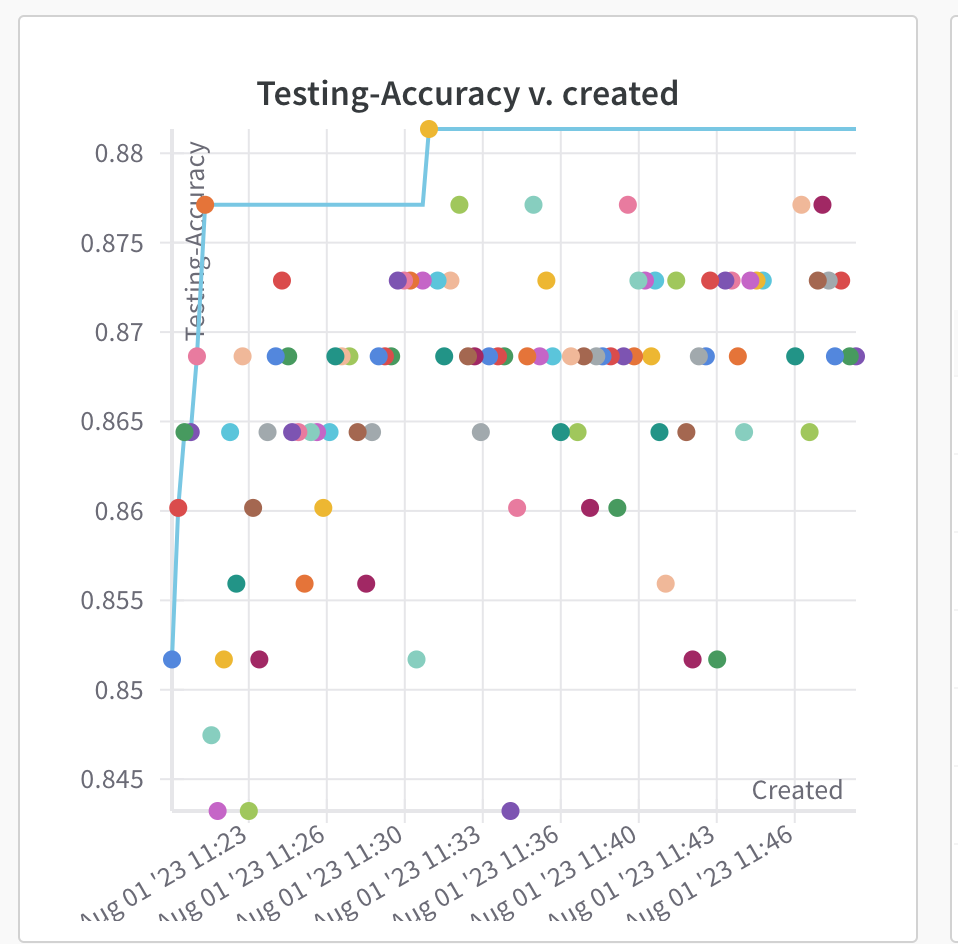

In [46]:
from IPython.display import Image

Image(filename='images/test_accuracy.png')

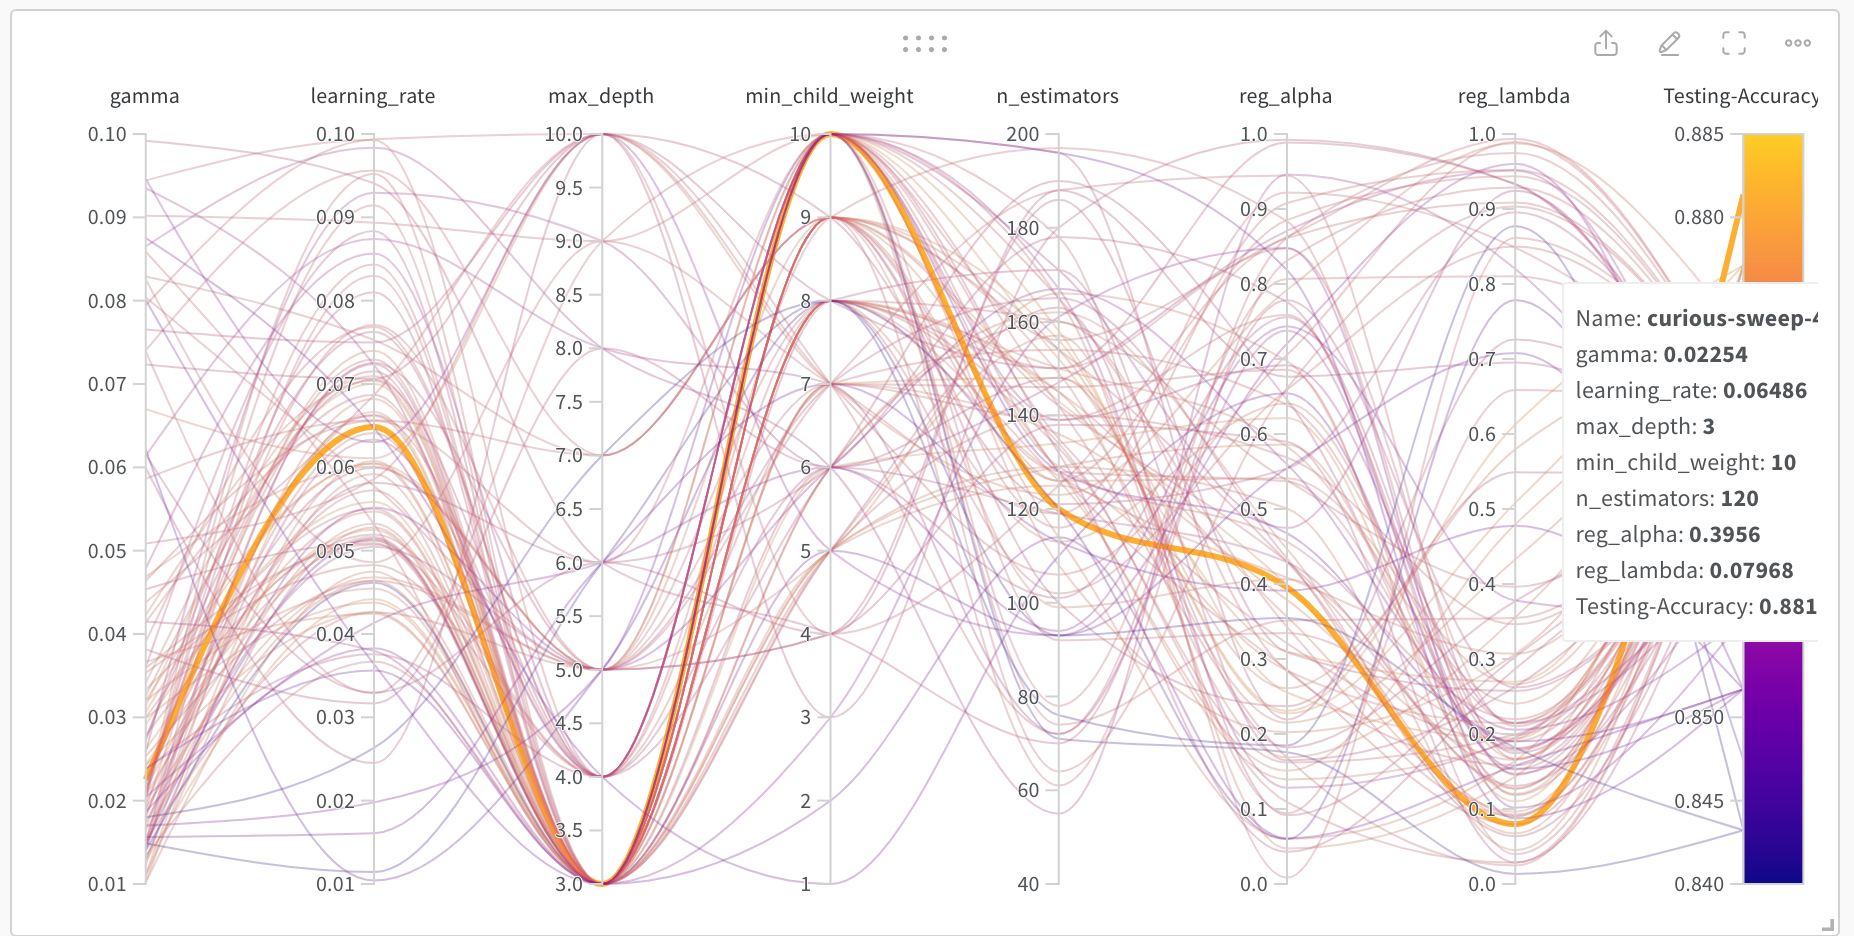

In [47]:
Image(filename='images/sweep_report.png')

Lets take a look at the parameters from the sweep. Note we didn't log all the model artifacts in the sweep. Lets run and save the best model now.

In [17]:
sweep_id = "w2o5fkw8"
api = wandb.Api()
sweep = api.sweep(f"qmavila/mlops-mortality-prediction/sweeps/{sweep_id}")

# Lets look at the best run
best_run = sweep.best_run()
best_parameters = best_run.config
print(best_run.name)

wandb: Sorting runs by -summary_metrics.Testing-Accuracy


curious-sweep-41


Curious-sweep-41 is our best run based on accuracy of .8814. We also had a number of runs at .8771

In [49]:
from pprint import pprint
pprint(best_parameters)

{'gamma': 0.02253646729240688,
 'learner': {'generic_param': {'fail_on_invalid_gpu_id': '0',
                               'gpu_id': '-1',
                               'n_jobs': '24',
                               'nthread': '24',
                               'random_state': '42',
                               'seed': '42',
                               'seed_per_iteration': '0',
                               'validate_parameters': '1'},
             'gradient_booster': {'gbtree_model_param': {'num_parallel_tree': '1',
                                                         'num_trees': '0',
                                                         'size_leaf_vector': '0'},
                                  'gbtree_train_param': {'predictor': 'auto',
                                                         'process_type': 'default',
                                                         'tree_method': 'hist',
                                                         'updater'

In [18]:
bst_params = {
    'objective': 'binary:logistic',
    'gamma': best_parameters['gamma'],
    'learning_rate': best_parameters['learning_rate'],
    'max_depth': best_parameters['max_depth'],
    'min_child_weight': best_parameters['min_child_weight'],
    'n_estimators': best_parameters['n_estimators'],
    'nthread': 24,
    'random_state': 42,
    'reg_alpha': best_parameters['reg_alpha'],
    'reg_lambda': best_parameters['reg_lambda'],
    'eval_metric': ['auc', 'logloss'],
    'tree_method': 'hist' 
        }

In [27]:
def run_best(bst_params, X, y):
    run = wandb.init(project="mlops-mortality-prediction", job_type='train-model')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    xgb_model = xgb.XGBClassifier(
        **bst_params,
        callbacks=[WandbCallback(log_model=True)]
    )


    # Train the XGBoost model
    xgb_model.fit(X_train, y_train)

    # Make predictions on the training set
    y_train_pred = xgb_model.predict(X_train)


    # Make predictions on the test set
    y_test_pred = xgb_model.predict(X_test)

    # Calculate accuracy for training and testing sets
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Calculate F1 score for training and testing sets
    train_f1_score = f1_score(y_train, y_train_pred)
    test_f1_score = f1_score(y_test, y_test_pred)

    # Calculate AUC-ROC score for training and testing sets
    train_auc_roc = roc_auc_score(y_train, xgb_model.predict_proba(X_train)[:, 1])
    test_auc_roc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])
    

    # 
    X_train['prediction'] = y_train_pred
    X_test['prediction'] = y_test_pred
    reference = X_test.copy()
    reference['outcome'] = y
    reference.to_parquet('data/reference.parquet')


    print("Training Accuracy:", train_accuracy)
    print("Testing Accuracy:", test_accuracy)
    print("Training F1 Score:", train_f1_score)
    print("Testing F1 Score:", test_f1_score)
    print("Training AUC-ROC:", train_auc_roc)
    print("Testing AUC-ROC:", test_auc_roc)

    run.log({
        "Train-Accuracy": train_accuracy,
        "Testing-Accuracy": test_accuracy,
        "Train-F1 Score": train_f1_score,
        "Testing-F1 Score": test_f1_score,
        "Train-AUC-ROC": train_auc_roc,
        "TestingAUC-ROC": test_auc_roc
    })
    run.finish()
    return X_train, X_test

In [28]:
reference_data, current_data = run_best(bst_params, X, y)

Training Accuracy: 0.9393617021276596
Testing Accuracy: 0.8813559322033898
Training F1 Score: 0.6984126984126984
Testing F1 Score: 0.48148148148148157
Training AUC-ROC: 0.979150247187791
Testing AUC-ROC: 0.807015306122449


Model has been saved and linked in the wandb registry through ui

# Lets check out a drift test using evidently

In [21]:
column_mapping = ColumnMapping(
    target=None,
    prediction='prediction',
)

In [22]:
report = Report(metrics=[
    ColumnDriftMetric(column_name='prediction'),
    DatasetDriftMetric(),
    DatasetMissingValuesMetric()
]
)

In [23]:
report.run(reference_data=reference_data, current_data=current_data, column_mapping=column_mapping)

/Users/qavila/.pyenv/versions/3.9.12/envs/tricorderai/lib/python3.9/site-packages/evidently/metrics/data_integrity/dataset_missing_values_metric.py:165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif missing_value in row.values:


In [24]:
report.show(mode='inline')